In [3]:
import torch
import torchvision 
import matplotlib.pyplot as plt 
from torchinfo import summary
from torchvision import transforms 

torch.__version__

'2.4.0'

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device: {device}")

Current device: cuda


In [10]:
# get data 
from data_setup import download_data

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi", remove_source=True)
image_path

[INFO] Did not find data\pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


WindowsPath('data/pizza_steak_sushi')

In [11]:
# setup directory paths for training and testing 
train_dir = image_path / "train"
test_dir = image_path / "test"

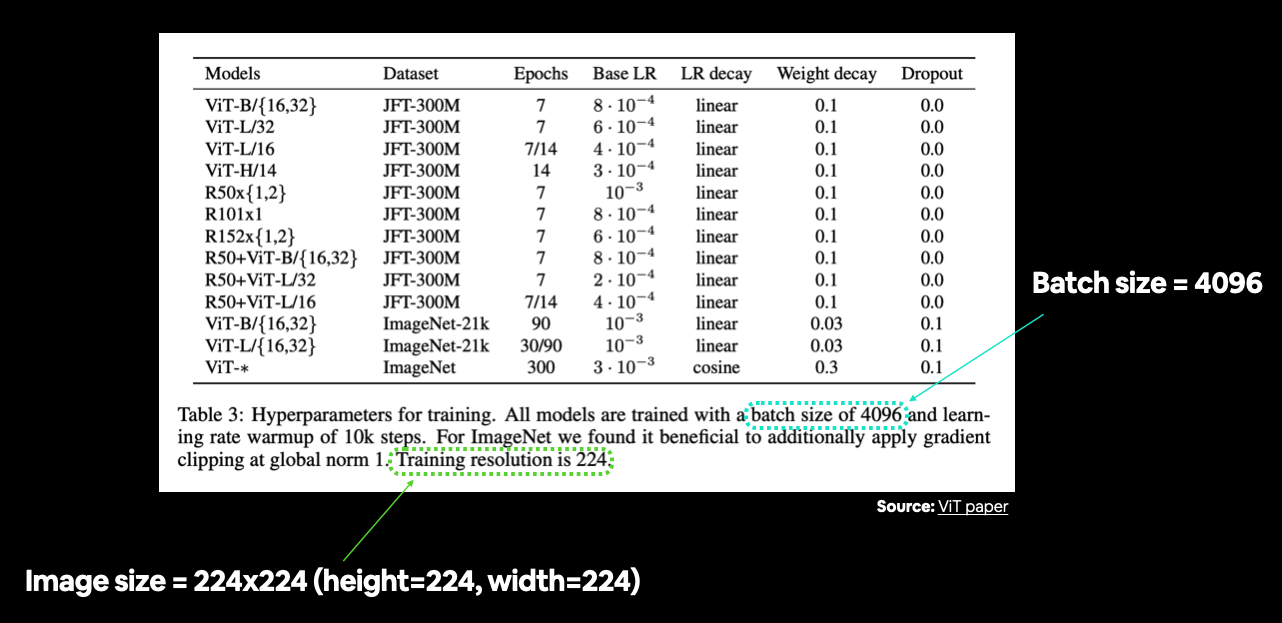

In [12]:
# setup image_size for transform according to table 3
IMAGE_SIZE = 224

manual_transform = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

We're using the pin_memory=True parameter in the create_dataloaders() function to speed up computation. pin_memory=True avoids unnecessary copying of memory between the CPU and GPU memory by "pinning" examples that have been seen before. Though the benefits of this will likely be seen with larger dataset sizes (our FoodVision Mini dataset is quite small).

In [13]:
# setup dataloaders for training and testing with batchsize of 32 (because we're working with small datasets)
from data_setup import create_dataloaders 
BATCH_SIZE = 32 

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir, test_dir=test_dir, train_transform=manual_transform, test_transform=manual_transform, batch_size=BATCH_SIZE)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e514a2d850>,
 ['pizza', 'steak', 'sushi'])

In [16]:
# take a look at one sample image 
image_batch, label_batch = next(iter(train_dataloader))
img, label = image_batch[0], label_batch[0]

# see the shape of the image 
img.shape

torch.Size([3, 224, 224])

Text(0.5, 1.0, 'sushi')

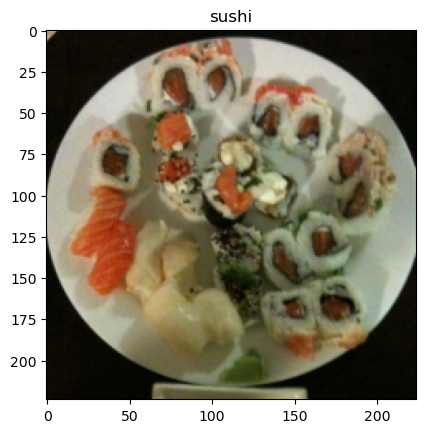

In [18]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label.item()])

## Inputs and Outputs Layer Block

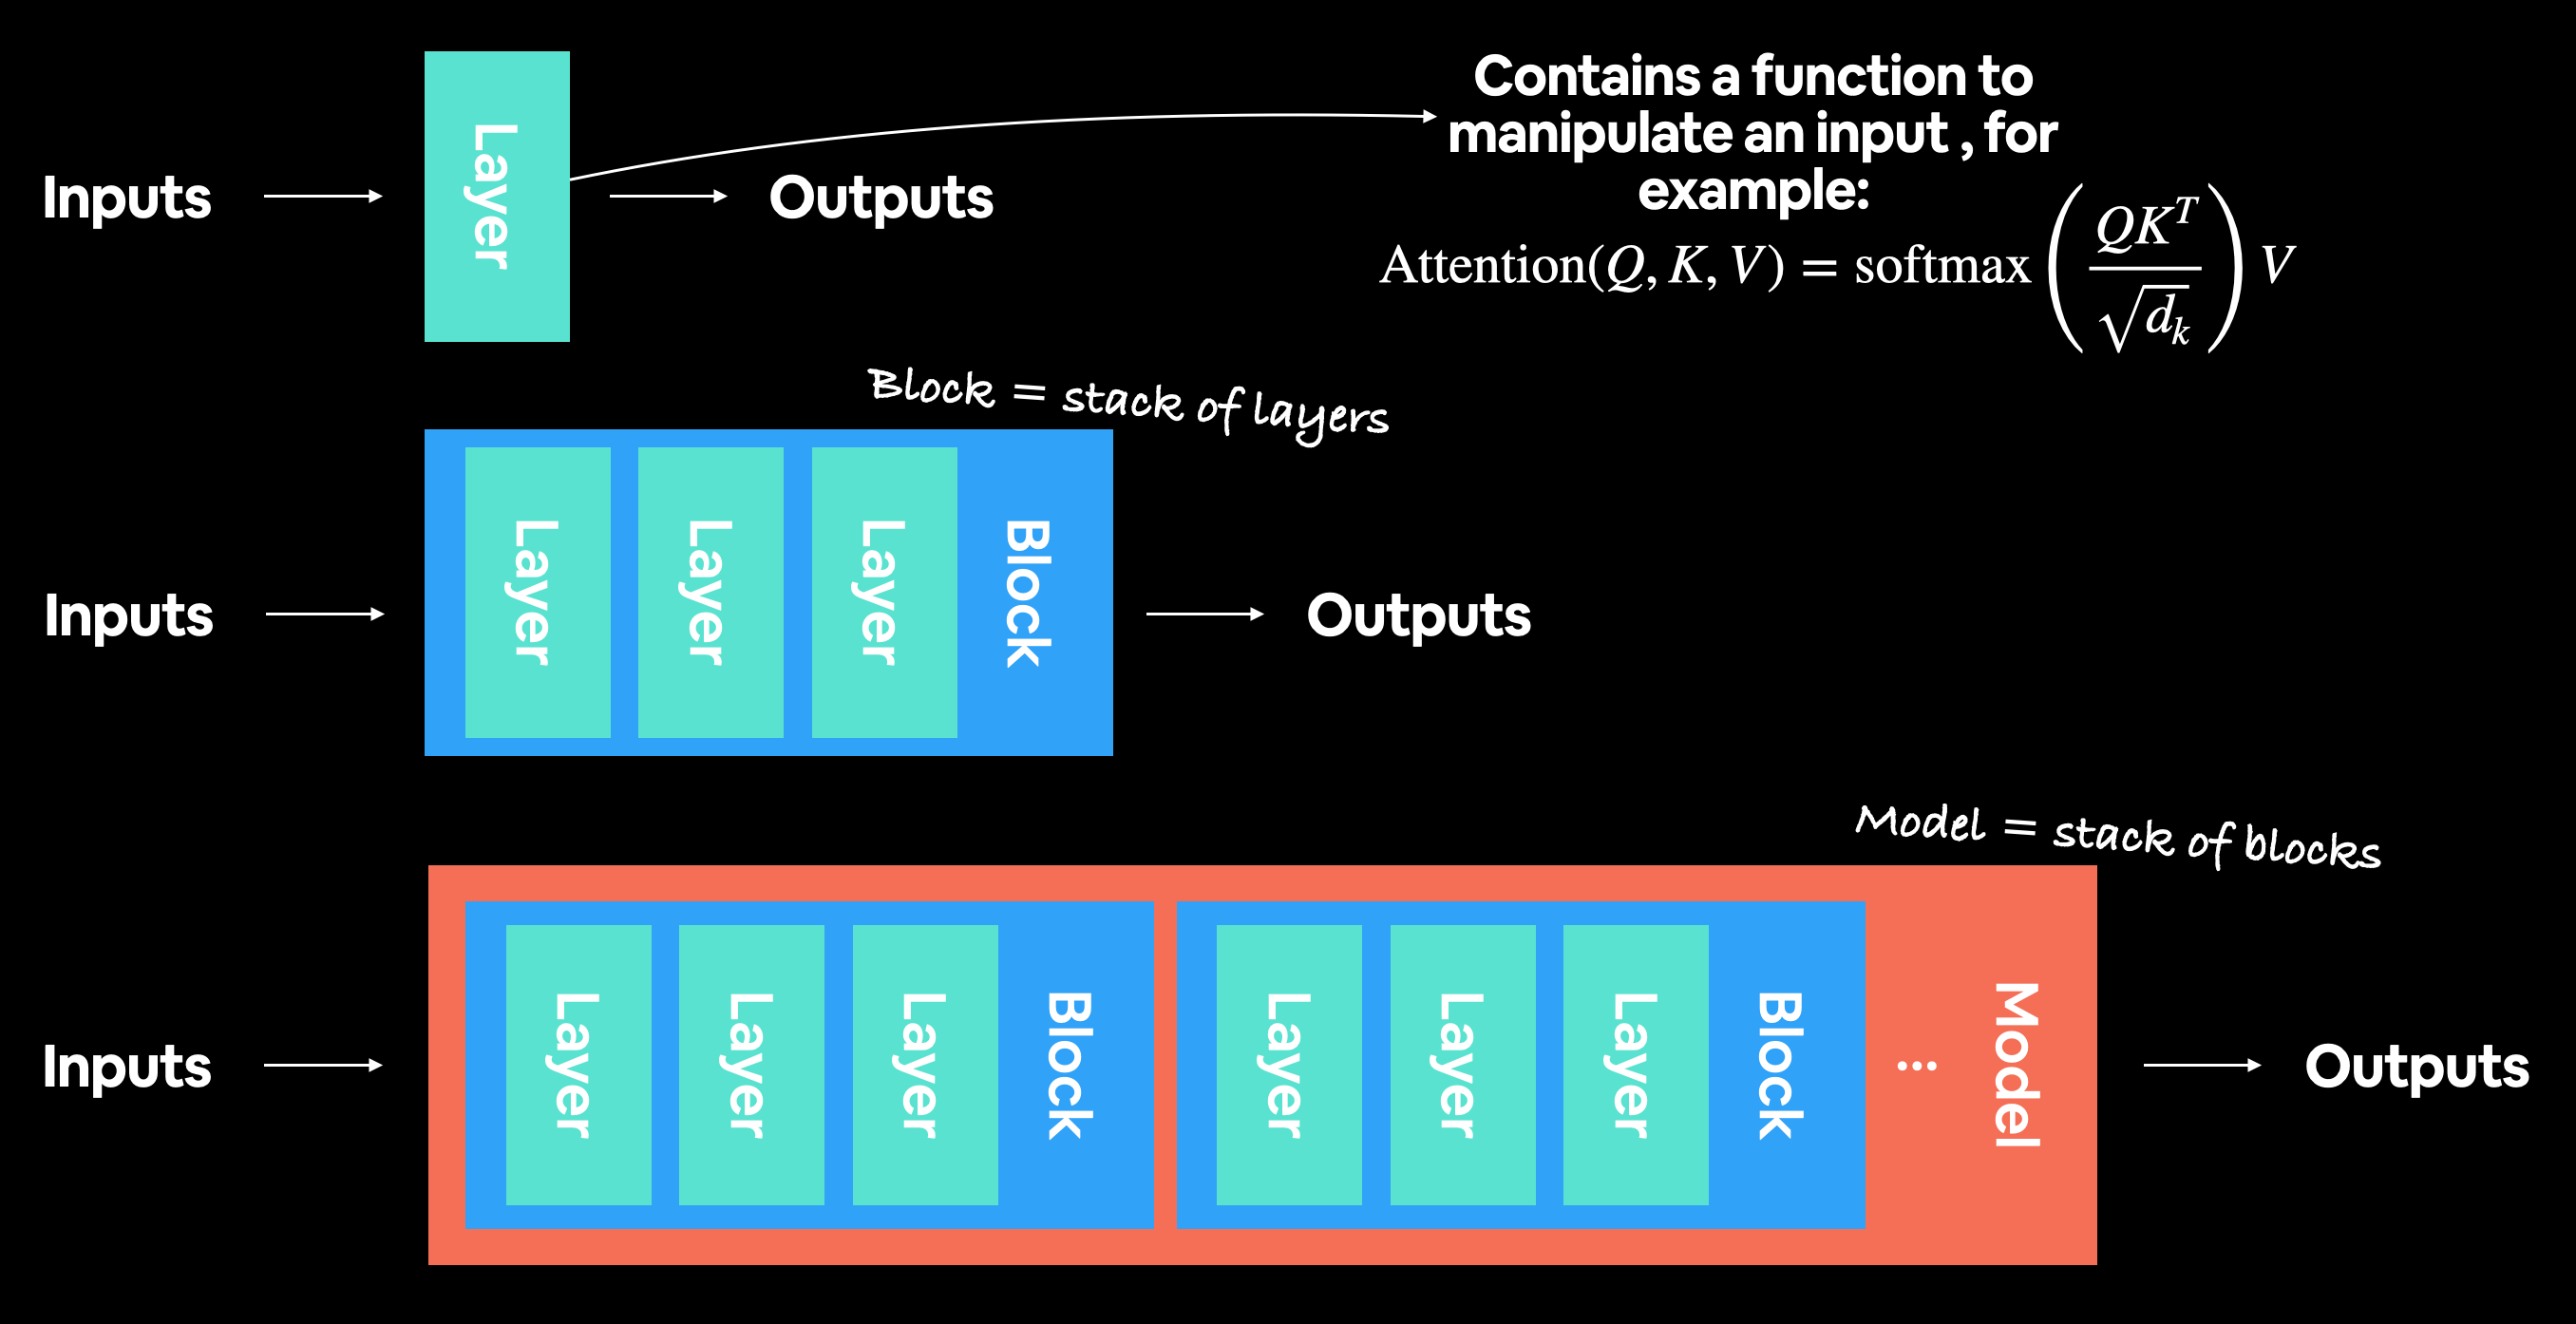

**note:** *A modern deep learning architecture is usually collection of layers and blocks. Where layers take an input (data as a numerical representation) and manipulate it using some kind of function (e.g. the self-attention formula), however this function could be almost anything and then output it. Blocks are generally stacks of layers on top of each other oding a similar thing to a single layer but multiple times.*

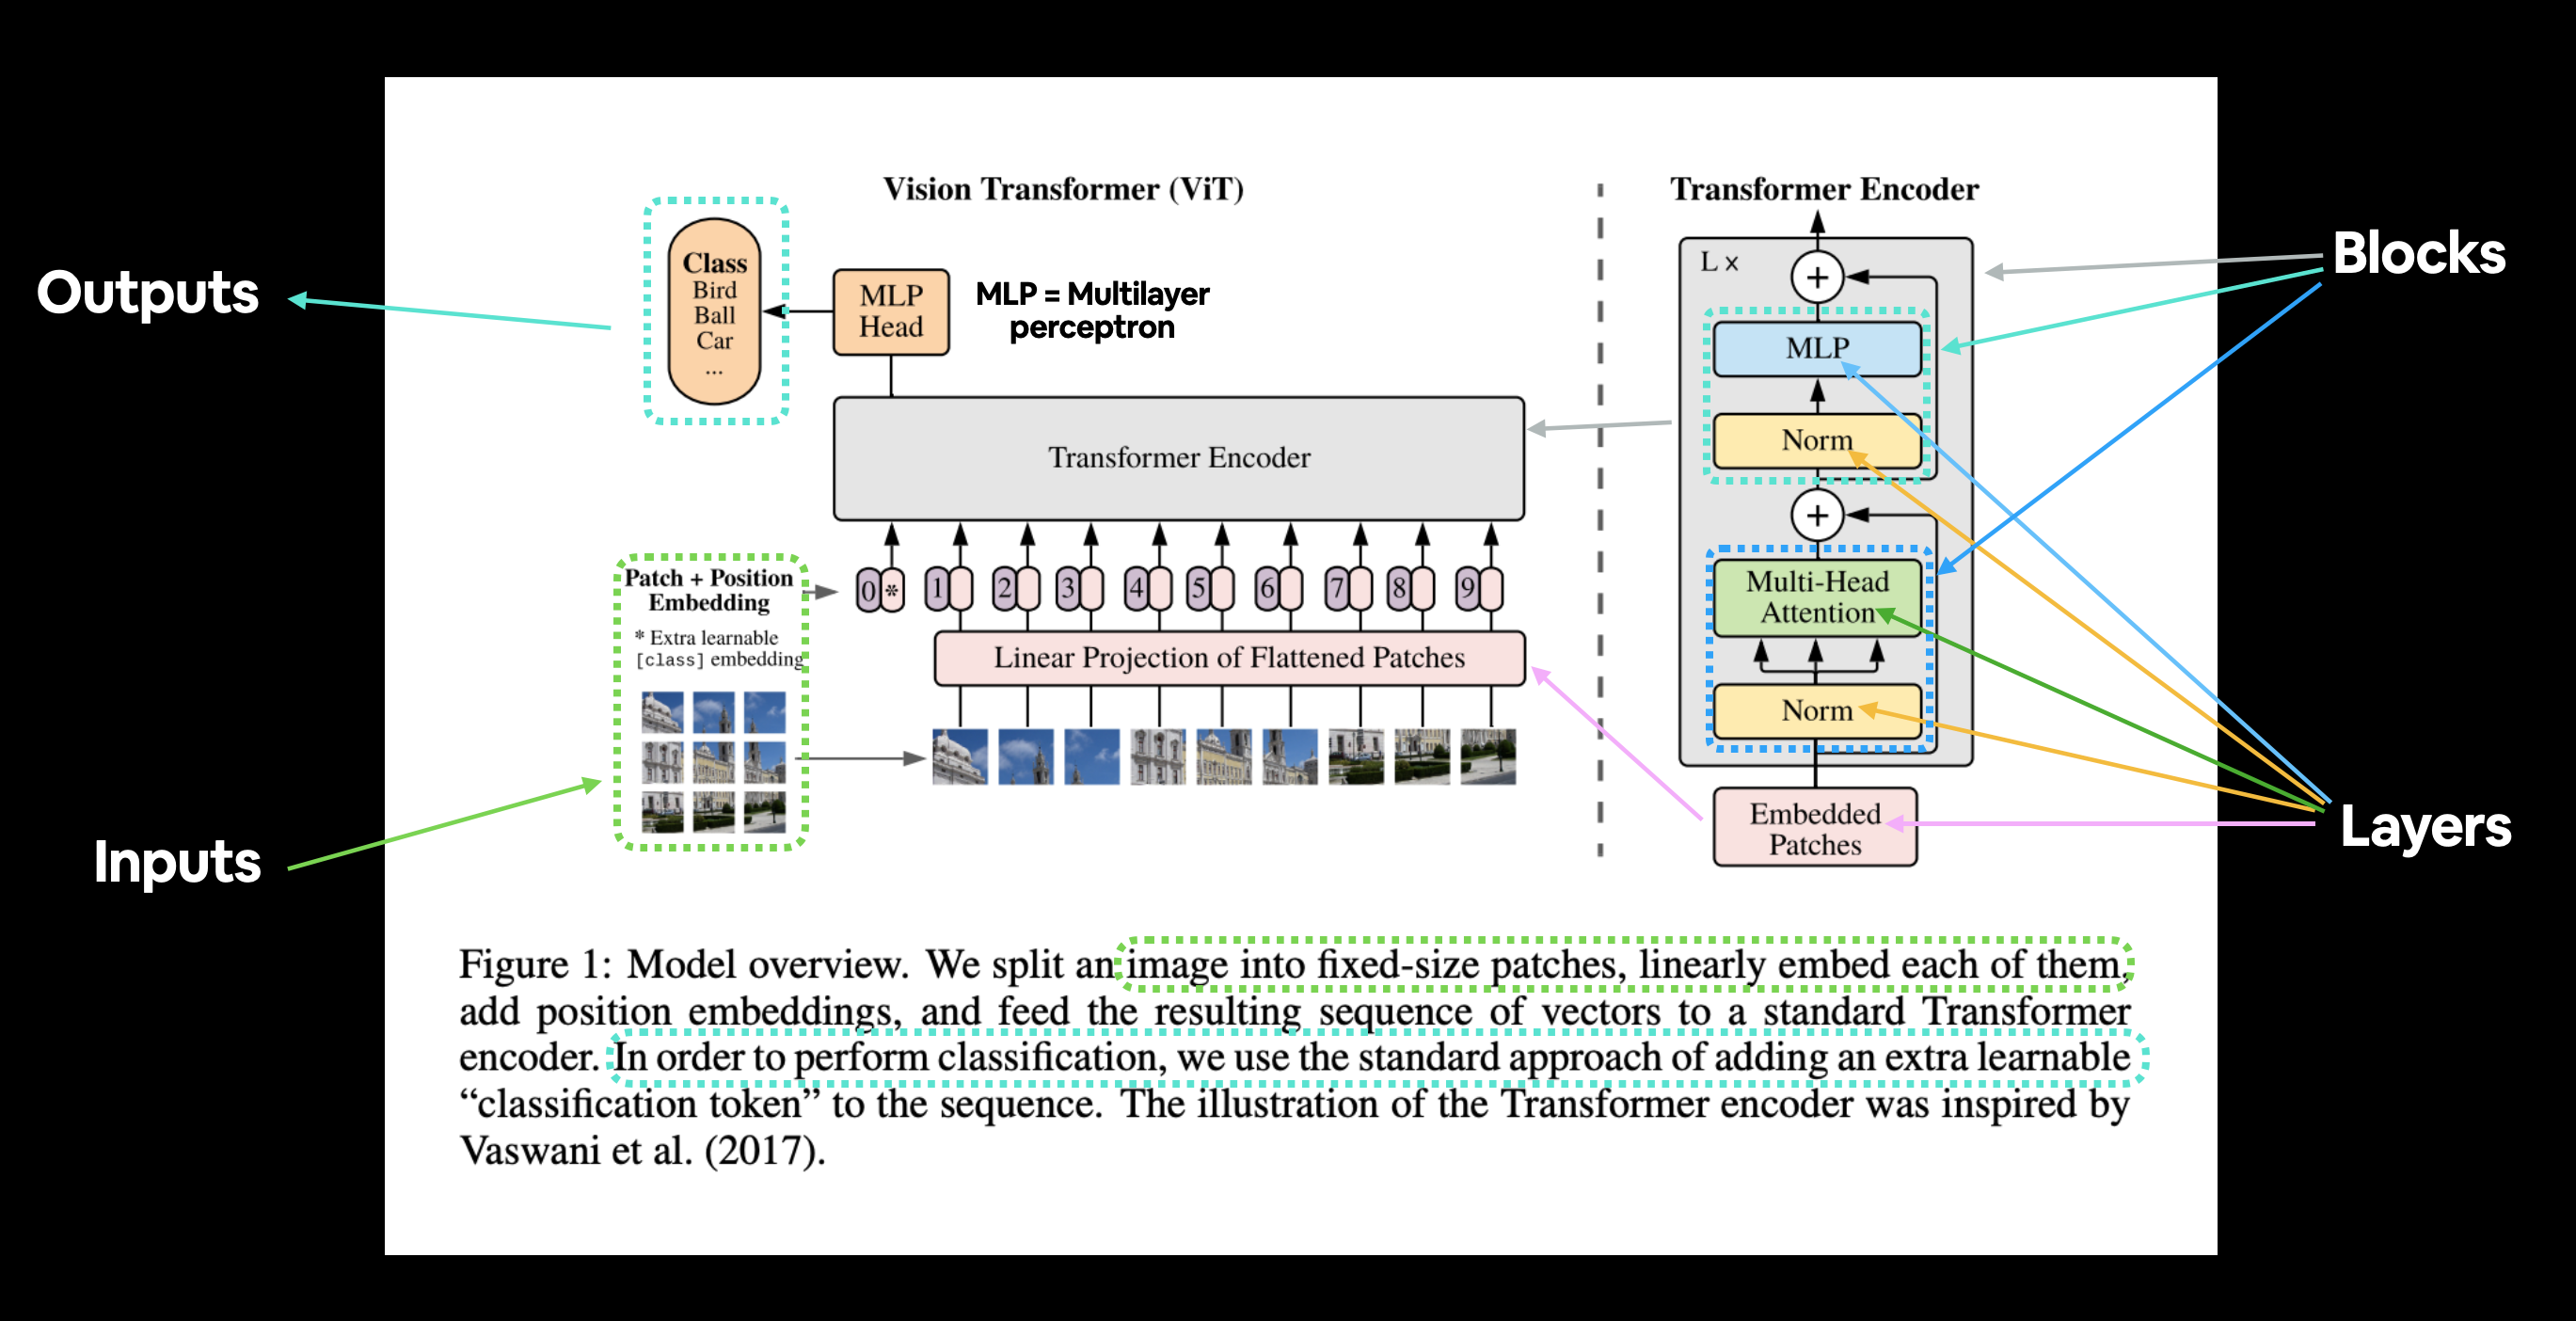

The ViT architecture is comprised of several stages: 
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in. 
* **Linear projection of flattened patches (Embedded patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is  learnable representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention Layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().
* **MLP (Multilayer Perceptron)** - An MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a *forward()* method). In the ViT paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them and a torch.nn.Dropout() layer after each.
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listen above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of  anumber of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the ouput layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the classifier head. The structure of the MLP Head is similar to the MLP block.

In [ ]:
# 3.2